In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('italy.csv')

In [2]:
data

,Time,Latitude,Longitude,Depth/Km,Magnitude
0,2016-08-24 03:36:32.000,42.6983,13.2335,8.1,6.0
1,2016-08-24 03:37:26.580,42.7123,13.2533,9.0,4.5
2,2016-08-24 03:40:46.590,42.7647,13.1723,9.7,3.8
3,2016-08-24 03:41:38.900,42.7803,13.1683,9.7,3.9
4,2016-08-24 03:42:07.170,42.7798,13.1575,9.7,3.6
...,...,...,...,...,...
8081,2016-11-30 18:39:27.600,42.8903,13.0197,10.7,2.0
8082,2016-11-30 18:43:14.850,42.9443,13.2003,8.6,2.6
8083,2016-11-30 20:18:27.550,43.0092,13.1288,8.0,2.2
8084,2016-11-30 20:45:11.780,43.0197,13.1017,9.3,2.7


In [4]:
data = data.rename(columns={'Latitude': 'lat', 'Longitude': 'long', 'Depth/Km': 'depth', 'Magnitude': 'mag'})
data

,Time,lat,long,depth,mag
0,2016-08-24 03:36:32.000,42.6983,13.2335,8.1,6.0
1,2016-08-24 03:37:26.580,42.7123,13.2533,9.0,4.5
2,2016-08-24 03:40:46.590,42.7647,13.1723,9.7,3.8
3,2016-08-24 03:41:38.900,42.7803,13.1683,9.7,3.9
4,2016-08-24 03:42:07.170,42.7798,13.1575,9.7,3.6
...,...,...,...,...,...
8081,2016-11-30 18:39:27.600,42.8903,13.0197,10.7,2.0
8082,2016-11-30 18:43:14.850,42.9443,13.2003,8.6,2.6
8083,2016-11-30 20:18:27.550,43.0092,13.1288,8.0,2.2
8084,2016-11-30 20:45:11.780,43.0197,13.1017,9.3,2.7


In [5]:
# Convert 'time' column to datetime
data['Time'] = pd.to_datetime(data['Time'])

# Extract only the date portion and rename the column
data['date'] = data['Time'].dt.date

# Reorder columns to place 'date' as the first column
data = data[['date', 'lat', 'long', 'depth', 'mag', 'Time']]

# Drop the original 'time' column if you no longer need it
data = data.drop(columns=['Time'])
data

,date,lat,long,depth,mag
0,2016-08-24,42.6983,13.2335,8.1,6.0
1,2016-08-24,42.7123,13.2533,9.0,4.5
2,2016-08-24,42.7647,13.1723,9.7,3.8
3,2016-08-24,42.7803,13.1683,9.7,3.9
4,2016-08-24,42.7798,13.1575,9.7,3.6
...,...,...,...,...,...
8081,2016-11-30,42.8903,13.0197,10.7,2.0
8082,2016-11-30,42.9443,13.2003,8.6,2.6
8083,2016-11-30,43.0092,13.1288,8.0,2.2
8084,2016-11-30,43.0197,13.1017,9.3,2.7


In [6]:
data = data[['date', 'mag']]
data

,date,mag
0,2016-08-24,6.0
1,2016-08-24,4.5
2,2016-08-24,3.8
3,2016-08-24,3.9
4,2016-08-24,3.6
...,...,...
8081,2016-11-30,2.0
8082,2016-11-30,2.6
8083,2016-11-30,2.2
8084,2016-11-30,2.7


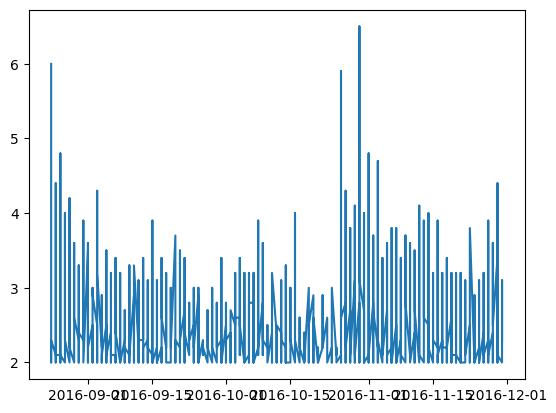

In [7]:
plt.plot(data['date'], data['mag'])

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [9]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['date'] = pd.to_datetime(df['date'])
    
    df.set_index('date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'mag(t-{i})'] = df['mag'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,mag,mag(t-1),mag(t-2),mag(t-3),mag(t-4),mag(t-5),mag(t-6),mag(t-7)
date,,,,,,,,
2016-08-24,3.2,2.7,3.4,3.6,3.9,3.8,4.5,6.0
2016-08-24,3.7,3.2,2.7,3.4,3.6,3.9,3.8,4.5
2016-08-24,2.8,3.7,3.2,2.7,3.4,3.6,3.9,3.8
2016-08-24,3.3,2.8,3.7,3.2,2.7,3.4,3.6,3.9
2016-08-24,2.9,3.3,2.8,3.7,3.2,2.7,3.4,3.6
...,...,...,...,...,...,...,...,...
2016-11-30,2.0,2.3,2.0,2.5,2.2,2.4,3.1,2.4
2016-11-30,2.6,2.0,2.3,2.0,2.5,2.2,2.4,3.1
2016-11-30,2.2,2.6,2.0,2.3,2.0,2.5,2.2,2.4


In [10]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[3.2, 2.7, 3.4, ..., 3.8, 4.5, 6. ],
       [3.7, 3.2, 2.7, ..., 3.9, 3.8, 4.5],
       [2.8, 3.7, 3.2, ..., 3.6, 3.9, 3.8],
       ...,
       [2.2, 2.6, 2. , ..., 2.5, 2.2, 2.4],
       [2.7, 2.2, 2.6, ..., 2. , 2.5, 2.2],
       [2.3, 2.7, 2.2, ..., 2.3, 2. , 2.5]])

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.46666667, -0.68888889, -0.37777778, ..., -0.2       ,
         0.11111111,  0.77777778],
       [-0.24444444, -0.46666667, -0.68888889, ..., -0.15555556,
        -0.2       ,  0.11111111],
       [-0.64444444, -0.24444444, -0.46666667, ..., -0.28888889,
        -0.15555556, -0.2       ],
       ...,
       [-0.91111111, -0.73333333, -1.        , ..., -0.77777778,
        -0.91111111, -0.82222222],
       [-0.68888889, -0.91111111, -0.73333333, ..., -1.        ,
        -0.77777778, -0.91111111],
       [-0.86666667, -0.68888889, -0.91111111, ..., -0.86666667,
        -1.        , -0.77777778]])

In [12]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((8079, 7), (8079,))

In [13]:
split_index = int(len(X) * 0.95)

split_index

7675

In [14]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7675, 7), (404, 7), (7675,), (404,))

In [15]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7675, 7, 1), (404, 7, 1), (7675, 1), (404, 1))

In [16]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([7675, 7, 1]),
 torch.Size([404, 7, 1]),
 torch.Size([7675, 1]),
 torch.Size([404, 1]))

In [17]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [18]:
train_dataset

In [19]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [24]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.558
Batch 200, Loss: 0.269
Batch 300, Loss: 0.036
Batch 400, Loss: 0.030

Val Loss: 0.025
***************************************************

Epoch: 2
Batch 100, Loss: 0.034
Batch 200, Loss: 0.029
Batch 300, Loss: 0.029
Batch 400, Loss: 0.029

Val Loss: 0.026
***************************************************

Epoch: 3
Batch 100, Loss: 0.030
Batch 200, Loss: 0.027
Batch 300, Loss: 0.031
Batch 400, Loss: 0.030

Val Loss: 0.026
***************************************************

Epoch: 4
Batch 100, Loss: 0.031
Batch 200, Loss: 0.027
Batch 300, Loss: 0.027
Batch 400, Loss: 0.031

Val Loss: 0.026
***************************************************

Epoch: 5
Batch 100, Loss: 0.029
Batch 200, Loss: 0.032
Batch 300, Loss: 0.028
Batch 400, Loss: 0.028

Val Loss: 0.025
***************************************************

Epoch: 6
Batch 100, Loss: 0.032
Batch 200, Loss: 0.031
Batch 300, Loss: 0.027
Batch 400, Loss: 0.026

Val Loss: 0.025
***************************

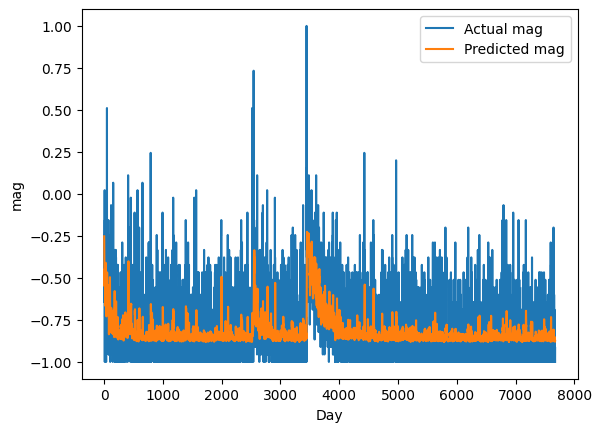

In [25]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual mag')
plt.plot(predicted, label='Predicted mag')
plt.xlabel('Day')
plt.ylabel('mag')
plt.legend()
plt.show()

In [26]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([3.68232354, 3.54664446, 3.43437819, ..., 2.27016081, 2.27490376,
       2.28207465])

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([3.2       , 3.7       , 2.79999995, ..., 2.19999999, 2.19999999,
       2.        ])

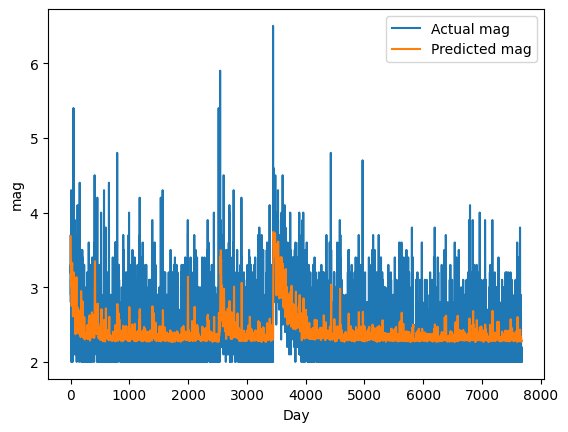

In [28]:
plt.plot(new_y_train, label='Actual mag')
plt.plot(train_predictions, label='Predicted mag')
plt.xlabel('Day')
plt.ylabel('mag')
plt.legend()
plt.show()

In [29]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([2.27979463, 2.27984412, 2.28048396, 2.27975427, 2.277395  ,
       2.28677092, 2.29371972, 2.28972967, 2.29735009, 2.30528782,
       2.33918478, 2.33858664, 2.32768185, 2.32887061, 2.3293054 ,
       2.35950197, 2.39108472, 2.41805486, 2.39719465, 2.38011153,
       2.36024454, 2.34676778, 2.30635373, 2.3032936 , 2.28429176,
       2.27921635, 2.28998233, 2.28734183, 2.28934276, 2.32735543,
       2.31804092, 2.3095579 , 2.30708718, 2.33559544, 2.34042396,
       2.35943425, 2.34108861, 2.32636958, 2.35047594, 2.34199761,
       2.31157224, 2.29791202, 2.28558338, 2.28031579, 2.28465801,
       2.27162047, 2.30140533, 2.35794549, 2.35231178, 2.34048216,
       2.32419512, 2.37106846, 2.40096503, 2.41645774, 2.37115161,
       2.35655731, 2.34512252, 2.36174631, 2.31926642, 2.33077122,
       2.34400564, 2.3281491 , 2.3304912 , 2.31623687, 2.2935081 ,
       2.28606912, 2.28291096, 2.30594121, 2.30652459, 2.31572926,
       2.30699532, 2.29578261, 2.28860891, 2.29414164, 2.27770

In [30]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([2.09999999, 2.09999999, 2.09999999, 2.        , 2.29999998,
       2.29999998, 2.        , 2.29999998, 2.29999998, 2.79999995,
       2.09999999, 2.09999999, 2.39999998, 2.19999999, 2.79999995,
       2.59999996, 2.89999995, 2.        , 2.09999999, 2.29999998,
       2.09999999, 2.        , 2.19999999, 2.09999999, 2.        ,
       2.29999998, 2.09999999, 2.19999999, 2.79999995, 2.        ,
       2.09999999, 2.09999999, 2.79999995, 2.29999998, 2.39999998,
       2.29999998, 2.        , 2.69999996, 2.        , 2.09999999,
       2.        , 2.        , 2.19999999, 2.        , 2.        ,
       2.69999996, 3.09999993, 2.        , 2.        , 2.09999999,
       2.99999994, 2.49999997, 2.59999996, 2.19999999, 2.09999999,
       2.19999999, 2.39999998, 2.09999999, 2.49999997, 2.59999996,
       2.        , 2.29999998, 2.        , 2.        , 2.        ,
       2.09999999, 2.79999995, 2.        , 2.39999998, 2.        ,
       2.        , 2.09999999, 2.09999999, 2.09999999, 2.39999

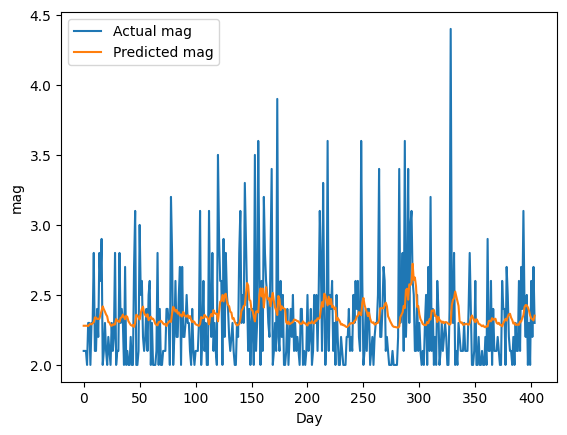

In [31]:
plt.plot(new_y_test, label='Actual mag')
plt.plot(test_predictions, label='Predicted mag')
plt.xlabel('Day')
plt.ylabel('mag')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(new_y_test, test_predictions)

# Calculate MAPE
mape = np.mean(np.abs((new_y_test - test_predictions) / new_y_test)) * 100

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(new_y_test, test_predictions))

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)

MAE: 0.27033074415464065
MAPE: 11.252377112344728
RMSE: 0.36181283077994847
